<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

<font color='red'>**Respuestas Provisionales**<font>

1. La escala la construyó el instituto CATO, un instituto de ciencias sociales con base en Washington. Evalúa la libertad personal y económica de los países, y a partir de los puntajes de éstos, obtiene un indicador final llamado "human freedom score" o libertad humana, con un rango posible del 0 al 10. Es importante considerar la procedencia del estudio en cuestión, con el fin de analizar posibles subjetividades en dichos puntajes.

A primera vista, un puntaje de 4.5 pensaríamos que está "a mitad de camino de los puntajes posibles", y podríamos pensar que implica un país con algunas libertades garantizadas y muchas no.
Pero mirando en una perspectiva global, el puntaje mínimo que se observa en más de 10 años de estudio, es un país con puntaje de libertad humana de 3.69 y un máximo de 9.12.

Por lo tanto un país con 4.5 está muy cerca de los países con menor cantidad de libertades garantizadas, esto además se suma a que la distribución de puntajes es muy densa en el rango entre 6 y 8.

2. La tendencia muestra que desde el 2008 se mantienen estables los puntajes de libertad de identidad en Latinoamérica, con un valor alto de alrededor de 9.5. Entre 2014 y 2015 hubo una caída del puntaje de libertad de identidad, que baja alrededor de dos puntos. Luego, un tendencia leve a mejorar este indicador.

En un rango de 10 años, Latinoamérica y el Caribe ha empeorado en este indicador. Hace unos 4 años que existe una tendencia al mejoramiento muy leve, que no podemos asegurar que se vaya a consolidar.

In [0]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import scipy
import scipy.stats as ss

In [0]:
seaborn.__version__

'0.10.1'

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [0]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [0]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [0]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [0]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [0]:
dataset.dtypes

year                                  int64
ISO_code                             object
countries                            object
region                               object
hf_score                             object
                                      ...  
ef_regulation_business_compliance    object
ef_regulation_business               object
ef_regulation                        object
ef_score                             object
ef_rank                              object
Length: 120, dtype: object

In [0]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
  dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


# Parte 1



## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  3. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  3. ¿Tiene sentido calcular la moda?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  

In [0]:
seaborn.set(font_scale=1.5)  # Para cambiar tamaño de labels en los gráficos

#### 1.1. Rango de las variables
Para las variables numéricas que son indicadores (excluimos el año), tomamos el valor máximo y el valor mínimo para cada una de ellas y luego calculamos la diferencia, que nos da el rango de cada variable.

In [0]:
print("Los rangos de las variables analizadas son:")
var_min = []
var_max = []
var_range = []

for score_col in score_cols:
    df_score_col = dataset[score_col]
    var_min.append(df_score_col.min())
    var_max.append(df_score_col.max())
    var_range.append(round(df_score_col.max()-df_score_col.min(),4)) #.round(4)
    #print(f"'{score_col}': rango: {var_range}, mínimo: {var_min}, máximo: {var_max}")
lista_rangos = list(zip(score_cols, var_range, var_min, var_max))
rangos = pandas.DataFrame(lista_rangos, columns=['variable', 'rango','min','max'])
rangos

Los rangos de las variables analizadas son:


,variable,rango,min,max
0,pf_identity_legal,10.00,0.00,10.00
1,pf_identity_sex_male,10.00,0.00,10.00
2,pf_identity_sex_female,10.00,0.00,10.00
3,pf_identity_sex,10.00,0.00,10.00
4,pf_identity_divorce,10.00,0.00,10.00
5,pf_identity,10.00,0.00,10.00
6,pf_score,7.34,2.22,9.56
7,pf_rank,161.00,1.00,162.00
8,ef_score,6.53,2.58,9.11
9,ef_rank,161.00,1.00,162.00


#### 1.2. Formas de comparar un país con otro

Si bien consideramos varias maneras de comparar países (calcular un estimador que pondere la media de cada país en toda la serie y la tendencia, tomar el valor puntual de cada variable en el último año para cada país, entre otros) creemos que la que mejor forma de comparar fue tomar la media por país y considerar la varianza de cada variable. Observar la varianza nos aporta una idea de cuán estable es la media que estamos observando. Para ejemplificar, observemos los barplots que se muestran a continuación: en ellos podemos ver la comparación entre Venezuela y Argentina. Si nos centramos en la variable 'pf_identity' podemos ver que la media no difiere tanto. Sin embargo, la varianza es significativamente distinta en cada país: en Argentina no hay varianza y en Venezuela es grande. Esto implica que Argentina es un país muy estable en cuanto a libertad personal y Venezuela no tanto.

Por otro lado, al tomar solo estos gráficos, perdemos de vista la variable temporal que es en dónde podemos encontrar alguna respuesta a la varianza observada. Es por eso que incluímos tambien un lineplot por año de cada variable. En este ejemplo en particular, vemos que Venezuela tuvo una fuerte caída de la libertad personal a partir del año 2014 pero entre los años 2008 y 2014 puntuó muy bien; eso explica que la varianza sea grande para Venezuela y nula para Argentina en este indicador. Además, al revisar ese cambio abrupto a partir del 2014 podríamos dar una explicación de lo sucedido en el país en particular.

En conclusión: si bien la media con la varianza ya es una buena forma de comparar países, es necasario mirar la evolucióón temporal con los lineplots  para profundizar el análisis. Sin embargo, los lineplots solos no sirven porque no siempre es tan evidente cuál es "mejor" (observar, por ejemplo, el lineplot de hf_score para Brasil y Bolivia).

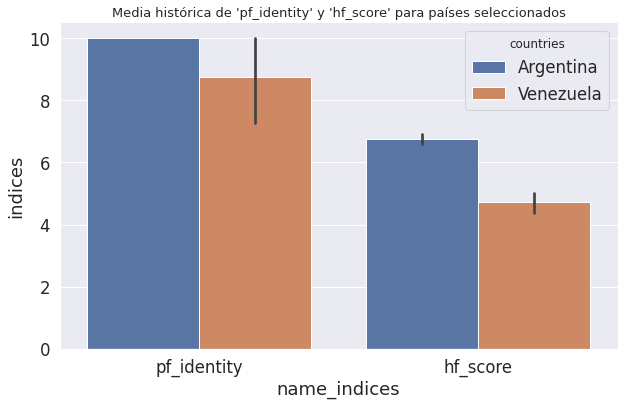

In [0]:

df_mean_melt = pandas.melt(dataset, id_vars=['countries','year'], value_vars = ['pf_identity', 'hf_score'], var_name='name_indices', value_name='indices')

pais_1 = 'Argentina'
pais_2 = 'Venezuela'

df_to_plot = df_mean_melt[(df_mean_melt.countries == pais_1) | (df_mean_melt.countries == pais_2)]

plt.figure(figsize=(10,6))
seaborn.barplot(data = df_to_plot, x ='name_indices', y='indices', hue='countries')
seaborn.despine()
plt.title("Media histórica de 'pf_identity' y 'hf_score' para países seleccionados", fontdict={'fontsize': 13})
plt.show()

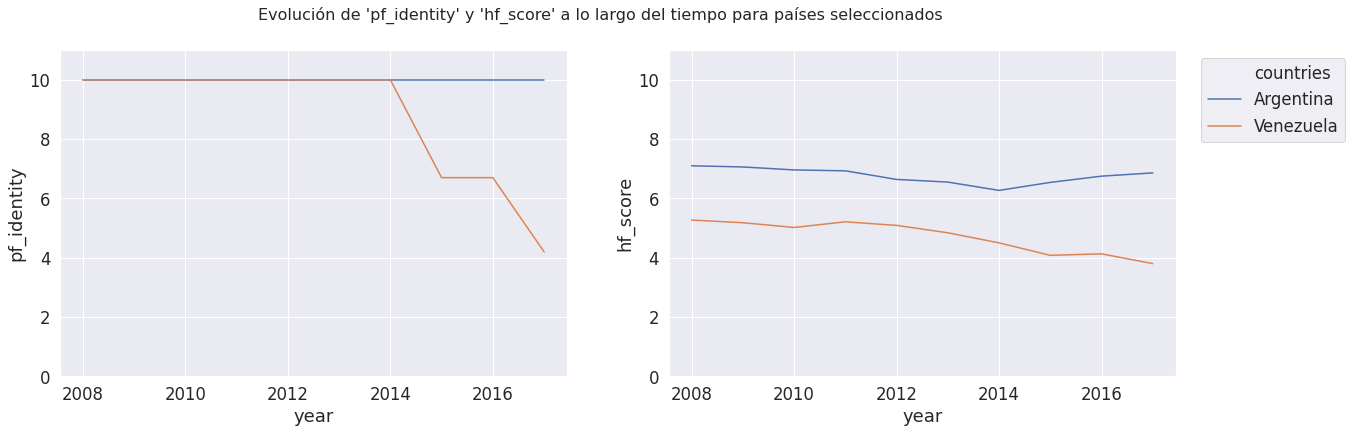

In [0]:
countries = ['Argentina', 'Venezuela']
sel_countries_filter = dataset['countries'].isin(countries)
df_sel_countries = dataset[sel_countries_filter]

fig, axs = plt.subplots(ncols=2, figsize=(20, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_sel_countries, x='year', y='pf_identity', hue='countries', ax=axs[0], legend=False)
seaborn.lineplot(data=df_sel_countries, x='year', y='hf_score', hue='countries', ax=axs[1])
n = 0
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10
plt.legend(bbox_to_anchor=(1.35, 1))  # para mover la leyenda a la derecha
fig.suptitle("Evolución de 'pf_identity' y 'hf_score' a lo largo del tiempo para países seleccionados", fontsize=16)

plt.show()

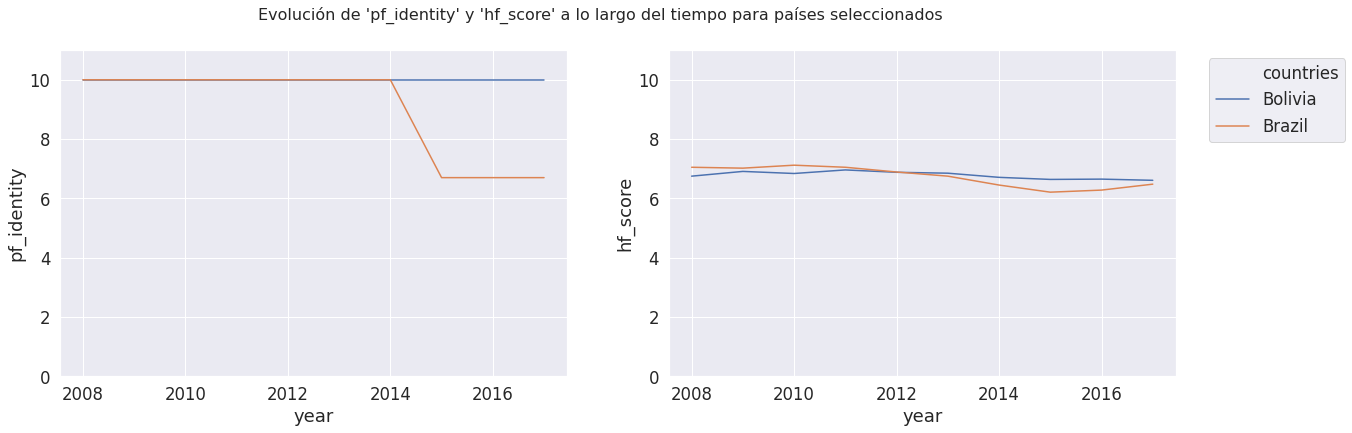

In [0]:
countries = ['Brazil', 'Bolivia']
sel_countries_filter = dataset['countries'].isin(countries)
df_sel_countries = dataset[sel_countries_filter]

fig, axs = plt.subplots(ncols=2, figsize=(20, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_sel_countries, x='year', y='pf_identity', hue='countries', ax=axs[0], legend=False)
seaborn.lineplot(data=df_sel_countries, x='year', y='hf_score', hue='countries', ax=axs[1])
n = 0
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10
plt.legend(bbox_to_anchor=(1.35, 1))  # para mover la leyenda a la derecha
fig.suptitle("Evolución de 'pf_identity' y 'hf_score' a lo largo del tiempo para países seleccionados", fontsize=16)

plt.show()

#### 1.3 Cálculo de media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo. Comparación con la de Latinoamérica y el caribe

Realizamos el cálculo de las medidas estadísticas a continuación. A partir de ellos, concluimos que no tiene mucho sentido tomar una medida como la media, dado que al hacerlo de esa forma se pierde información sobre, por ejemplo, cómo viene evolucionando el indicador en el tiempo, además que valores extremos pueden estar distorsionando la media.

**pf_identity**:

Media del mundo: 7.28; Media de LA: 8.58

Mediana del mundo: 8.8; Mediana de LA: 10.0

Desviación estándar del mundo: 3.18; Desviación estándar de LA: 1.87

Media y Mediana: se observa que tanto en la región Latinoamérica y el Caribe como en el mundo, la mediana es mayor al valor de la media, dando una pauta de que la variable no se distribuye simétricamente. Por otro lado, sí se considera a cualquiera de los dos estadísticos como valor típico y se toma un criterio de disntiguibilidad de una desviación estándar (generalmente se toman dos o tres desviaciones). Se podría concluir que en Latinoamérica y el Caribe la apreciación de libertad personal no difiere de la apreciación mundial.

Desviación Estándar: la desviación que presenta esta variable a nivel mundial respecto a Latinoamérica y el Caribe es de un 70%, lo cual es de esperar, ya que el aumento de la diversidad cultural conlleva a que se presenten distintas apreciaciones de libertad, siendo esta variable sensible a muchos factores sociales. 

Si bien para el caso de Latinoamérica y el Caribe la mediana es el valor más representativo para caracterizarla, coincidiendo ésta con el valor modal, no ocurre lo mismo en el mundo, pues la mediana deja de ser representativa ya que queda fuera del intervalo modal y la moda pasa a representar a la mayoría de los casos (siempre que esta mayoría tenga valor estadístico para el análisis). 

Respecto a si tiene sentido calcular la moda, en este caso sí, primero por la naturaleza de la variable (i.e. variable discreta) y segundo porque, si bien se pueden ver otros valores con frecuencias notables, la moda en ambos casos representa a la mayoría de los casos.

**hf_score**: 

Media del mundo: 6.97; Media de LA: 7.03

Mediana del mundo: 6.9; Mediana de LA: 7.02

Desviación estándar del mundo: 1.05; Desviación estándar de LA: 0.63

Media y Mediana: toman el mismo valor, tanto en Latinoamérica y el Caribe como en el mundo, por lo tanto no se descarta que esta variable obedezca a una distribución normal. Sin embargo, es necesario conocer la distribución de la muestra con el fin de tener la seguridad que los valores de centralización caen sobre un único intervalo modal.

Desviación Estándar: del mismo modo que la variable pf_identity, la desviación éstandar de Latinoamérica y el Caribe es menor que la del mundo.

In [0]:
selected_scores = ['pf_identity', 'hf_score']
la_filter = dataset['region'] == 'Latin America & the Caribbean'
dataset_la = dataset[la_filter]

for score in selected_scores:
    df_score_world = dataset[score]
    df_score_la = dataset_la[score]
    # Mean
    mean_world = df_score_world.mean()
    mean_la = df_score_la.mean()
    # Median
    median_world = df_score_world.median()
    median_la = df_score_la.median()
    # Standard deviation
    std_world = df_score_world.std()
    std_la = df_score_la.std()
    
    print(f"Respecto a la variable '{score}', los valores del mundo respecto a LA son:")
    print(f"Media del mundo: {round(mean_world,3)}; Media de LA: {round(mean_la,3)}")
    print(f"Mediana del mundo: {round(median_world,3)}; Mediana de LA: {round(median_la,3)}")
    print(f"Desviación estándar del mundo: {round(std_world,3)}; Desviación estándar de LA: {round(std_la,3)}\n")

Respecto a la variable 'pf_identity', los valores del mundo respecto a LA son:
Media del mundo: 7.281; Media de LA: 8.582
Mediana del mundo: 8.8; Mediana de LA: 10.0
Desviación estándar del mundo: 3.182; Desviación estándar de LA: 1.876

Respecto a la variable 'hf_score', los valores del mundo respecto a LA son:
Media del mundo: 6.978; Media de LA: 7.037
Mediana del mundo: 6.9; Mediana de LA: 7.02
Desviación estándar del mundo: 1.056; Desviación estándar de LA: 0.635



#### 1.4 Cálculo de moda: ¿tiene sentido?

Respecto a si tiene sentido calcular la moda, depende de la variable. En el caso de _'pf_identity'_ sí, por la naturaleza de la variable discreta resulta de utilidad conocer el valor que más se repite.

En el caso de _'hf_score'_, la varable es contínua. La probabilidad de ocurrencia de un mismo valor es muy baja, de esta manera la moda no es un buen estadístico de centralización. Si se efectuara un redondeo a un decimal, entonces los valores se repetirían (se estaría en cierto modo, discretizando la variable). Para estos casos, por lo general, resulta de mayor utilidad trabajar con intervalos modales y no con un valor de moda.

In [0]:
for score in selected_scores:
    df_score_world = dataset[score]
    df_score_la = dataset_la[score]
    # Mode
    mode_world = df_score_world.mode()
    mode_la = df_score_la.mode()
    
    print(f"Respecto a la variable '{score}', los valores del mundo respecto a LA son:")
    print(f"Moda del mundo: {mode_world}; Media de LA: {mode_la}\n")


Respecto a la variable 'pf_identity', los valores del mundo respecto a LA son:
Moda del mundo: 0    10.0
dtype: float64; Media de LA: 0    10.0
dtype: float64

Respecto a la variable 'hf_score', los valores del mundo respecto a LA son:
Moda del mundo: 0    6.75
dtype: float64; Media de LA: 0    6.72
dtype: float64



#### 1.5 ¿Cómo sanear los valores faltantes?
Hay diferentes formas que uno podría pensar para sanear los valores faltantes:
1. ##### Sustitución por la Media: 
Consiste en sustituir el valor ausente por la Media de los valores válidos. Este procedimiento plantea inconvenientes como:
- Dificulta la estimación de la Varianza.
- Distorsiona la verdadera distribución de la variable,
- Distorsiona la correlación entre variables dado que añade valores constantes.
2. ##### Sustitución por constante: 
Consiste en sustituir los valores ausentes por constantes cuyo valor viene determinado por razones teóricas o relacionadas con la investigación previa. Presenta los mismos inconvenientes que la sustitución por la Media, y solo debe ser utilizado si hay razones para suponer que es más adecuado que el método de la media.
3. ##### Imputación por regresión: 
Este método consiste en estimar los valores ausentes en base a su relación con otros variables mediante Análisis de Regresión. Inconvenientes:
- Incrementa artificialmente las relaciones entre variables.
- Hace que se subestime la Varianza de las distribuciones.
- Asume que las variables con datos ausentes tienen relación de alta magnitud con las otras variables.

Dado este conjunto de datos en particular, una buena opción es rellenar estos datos faltantes con la media del propio país, o con la media de la región, o con la media de algún país que se lo considere similar en el aspecto en cuestión.
Si se trata de una serie de tiempo, es posible considerar la interpolación del valor faltante mediante el ajuste de una curva a los datos que tengamos disponibles.

In [0]:
print("Cantidad de valores faltantes por columna:\n")
dataset.isna().sum()

Cantidad de valores faltantes por columna:



year                         0
ISO_code                     0
countries                    0
region                       0
pf_identity_legal         1312
pf_identity_sex_male        83
pf_identity_sex_female      80
pf_identity_sex             80
pf_identity_divorce        101
pf_identity                 80
pf_score                    80
pf_rank                     80
ef_score                    80
ef_rank                     80
hf_score                    80
hf_rank                     80
dtype: int64

In [0]:
def calculate_measure_by_column(df, col, agg='mean'):
    """
    Performs aggregation over col and fills NaN values of df with the result.
    """
    
    # Calculate measure by column
    df_by_col_and_year = df.copy()
    df_by_col_and_year = df_by_col_and_year.set_index([col, 'year'])[score_cols]
    df_measure_by_col = df_by_col_and_year.groupby([col]).agg(agg).reset_index()
    renamed_columns_dict = {col: col + '_measure' for col in score_cols}
    df_measure_by_col = df_measure_by_col.rename(columns=renamed_columns_dict)  # rename columns so that they are different than the ones in the original dataframe
    # Join measure to dataframe
    df_new = df.merge(df_measure_by_col, on=col, how='left')
    for score in score_cols:
        df_new[score] = numpy.where(df_new[score].isna(), df_new[score + '_measure'], df_new[score])
    df_new = df_new.drop(columns=renamed_columns_dict.values())
    return df_new

In [0]:
df_clean = calculate_measure_by_column(dataset, 'countries', agg='mean')

print("Cantidad de valores faltantes por columna luego de limpieza por país:\n")
df_clean.isnull().sum()

Cantidad de valores faltantes por columna luego de limpieza por país:



year                        0
ISO_code                    0
countries                   0
region                      0
pf_identity_legal         590
pf_identity_sex_male        0
pf_identity_sex_female      0
pf_identity_sex             0
pf_identity_divorce         0
pf_identity                 0
pf_score                    0
pf_rank                     0
ef_score                    0
ef_rank                     0
hf_score                    0
hf_rank                     0
dtype: int64

Como aún quedan valores vacíos, calculamos la media por región y se completamos los NaN restantes

In [0]:
df_clean = calculate_measure_by_column(df_clean, 'region', agg='mean')

print("Cantidad de valores faltantes por columna luego de limpieza por país y región:\n")
df_clean.isnull().sum()

Cantidad de valores faltantes por columna luego de limpieza por país y región:



year                      0
ISO_code                  0
countries                 0
region                    0
pf_identity_legal         0
pf_identity_sex_male      0
pf_identity_sex_female    0
pf_identity_sex           0
pf_identity_divorce       0
pf_identity               0
pf_score                  0
pf_rank                   0
ef_score                  0
ef_rank                   0
hf_score                  0
hf_rank                   0
dtype: int64

#### 1.6. Outliers
Formas de detectarlos:
1. Gráficamente: realizando un boxplot por región, es posible distinguir, para cada región, algunas observaciones que se ubican fuera del intervalo de confianza definido en el boxplot (los puntos fuera del rango de los "bigotes"). También podría buscarse outliers dentro de una región por país.
2. Normalizando los valores por región, calculando la media y eligiendo una cantidad determinada de desviaciones estándar desde la media a partir de la cual consideramos que esos países son outliers.

##### 1.6.1. Detección de outliers de manera gráfica

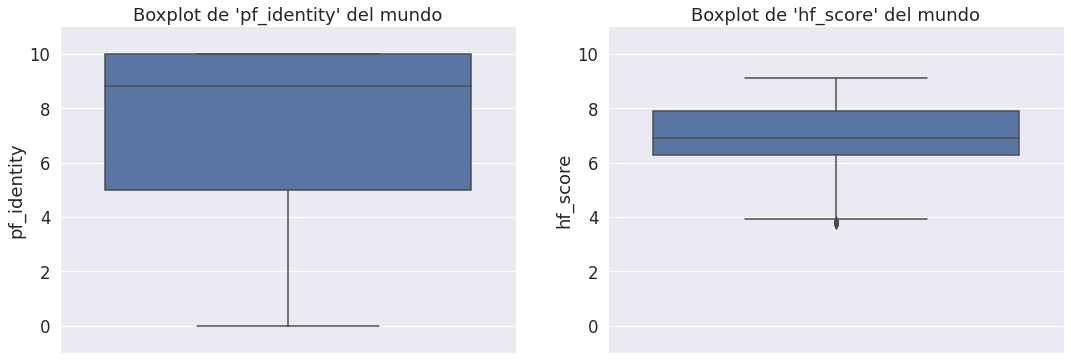

In [0]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.boxplot(y=dataset['pf_identity'], ax=axs[0])
seaborn.boxplot(y=dataset['hf_score'], ax=axs[1])
for ax in axs:
    ax.set_ylim(-1, 11)  # eje y no puede ser menor a 0 ni mayor a 10
    ax.tick_params(axis='x', labelrotation=90, labelsize=12)

axs[0].title.set_text("Boxplot de 'pf_identity' del mundo")
axs[1].title.set_text("Boxplot de 'hf_score' del mundo")
seaborn.despine()

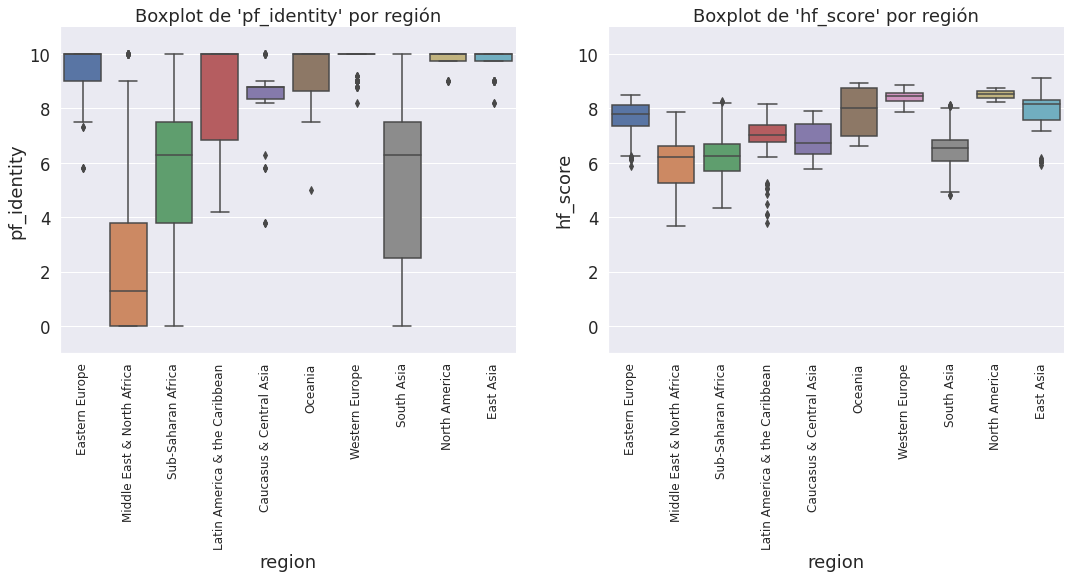

In [0]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.boxplot(x=dataset['region'], y=dataset['pf_identity'], ax=axs[0])
seaborn.boxplot(x=dataset['region'], y=dataset['hf_score'], ax=axs[1])
for ax in axs:
    ax.set_ylim(-1, 11)  # eje y no puede ser menor a 0 ni mayor a 10
    ax.tick_params(axis='x', labelrotation=90, labelsize=12)

axs[0].title.set_text("Boxplot de 'pf_identity' por región")
axs[1].title.set_text("Boxplot de 'hf_score' por región")
seaborn.despine()

##### 1.6.2. Detección de outliers a partir de su probabilidad de ocurrencia

In [0]:
def find_outliers(data, selected_score, number_of_stds):
    """Returns ouliers based on a number of standard deviations from the mean (number_of_stds) for a given column (selected_score)
    """
    dfs_outliers = []
    for region in data['region'].unique():
        for year in data['year'].unique():
            dataset_reg = data[(data['region'] == region) & (data['year'] == year)]
            score = dataset_reg[selected_score]
            score_mean = score.mean()
            score_median = score.median()
            abs_diff = numpy.abs(score - score_mean)
            score_std = score.std()
            outlier_mask = abs_diff > (score_std * number_of_stds)
            df_region_outliers = dataset_reg[outlier_mask][['year', 'countries', 'region', selected_score]]
            df_region_outliers[selected_score + '_mean'] = round(score_mean,3) #.round(3)
            df_region_outliers[selected_score + '_median'] = round(score_median,3) #.round(3)
            df_region_outliers[selected_score + '_std'] = round(score_std,3) #.round(3)
            df_region_outliers = df_region_outliers.sort_values(by=['countries', 'year'])
            dfs_outliers.append(df_region_outliers)

    df_outliers = pandas.concat(dfs_outliers)

    return df_outliers

##### 1.6.2.a. Detección de outliers para 'pf_identity'

In [0]:
df_outliers_pf_identity = find_outliers(dataset, 'pf_identity', number_of_stds=2.5)

df_outliers_pf_identity

,year,countries,region,pf_identity,pf_identity_mean,pf_identity_median,pf_identity_std
0,2017,Albania,Eastern Europe,5.8,8.836,9.0,0.906
162,2016,Albania,Eastern Europe,5.8,9.014,9.0,0.970
324,2015,Albania,Eastern Europe,5.8,9.052,9.0,0.977
543,2014,Greece,Eastern Europe,7.5,9.824,10.0,0.593
687,2013,Cyprus,Eastern Europe,7.5,9.705,10.0,0.778
705,2013,Greece,Eastern Europe,7.5,9.705,10.0,0.778
849,2012,Cyprus,Eastern Europe,7.5,9.705,10.0,0.778
867,2012,Greece,Eastern Europe,7.5,9.705,10.0,0.778
1011,2011,Cyprus,Eastern Europe,7.5,9.705,10.0,0.778
1029,2011,Greece,Eastern Europe,7.5,9.705,10.0,0.778


##### 1.6.2.a. Detección de outliers para 'hf_score'

In [0]:
df_outliers_hf_score = find_outliers(dataset, 'hf_score', number_of_stds=2.5)

df_outliers_hf_score

,year,countries,region,hf_score,hf_score_mean,hf_score_median,hf_score_std
476,2015,Ukraine,Eastern Europe,5.88,7.646,7.820,0.706
1096,2011,Russia,Eastern Europe,6.43,7.736,7.880,0.517
1420,2009,Russia,Eastern Europe,6.41,7.731,7.870,0.517
137,2017,Sudan,Sub-Saharan Africa,4.32,6.231,6.315,0.671
299,2016,Sudan,Sub-Saharan Africa,4.44,6.243,6.360,0.714
744,2013,Mauritius,Sub-Saharan Africa,8.13,6.286,6.345,0.702
906,2012,Mauritius,Sub-Saharan Africa,8.29,6.185,6.170,0.739
1068,2011,Mauritius,Sub-Saharan Africa,8.25,6.232,6.130,0.730
1230,2010,Mauritius,Sub-Saharan Africa,8.19,6.263,6.270,0.687
1392,2009,Mauritius,Sub-Saharan Africa,8.10,6.235,6.160,0.670


##### Dataset sin outliers

In [0]:
dataset_wo_outliers = dataset[~dataset.index.isin(df_outliers_pf_identity.index)]
dataset_wo_outliers = dataset_wo_outliers[~dataset_wo_outliers.index.isin(df_outliers_hf_score.index)]

dataset_wo_outliers

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
5,2017,AUS,Australia,Oceania,7.0,10.0,10.0,10.0,10.0,9.0,9.16,12.0,8.07,9.0,8.62,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


Para detectar observaciones outliers, lo que hicimos fue verificar, para cada región y año, qué países se apartaban de la media en más de 2.5 desviaciones estándar.<br>
Los valores observados de estos países en dichos años no parecen ser producto de errores de carga o de estimación (esperaríamos valores absurdos para pensar de que se trata de un error). A su vez, en esta lista podemos ver a Venezuela y Rusia como países cuya Human Freedom se caracteriza por estar significativamente por debajo de la media de su región, lo cual no parece ser sorpresivo conociendo los hechos que sucedieron en estos países.<br>
Por otra parte, no existen países que sean outliers tanto para 'pf_identity' como para 'hf_score', por lo que eliminar un punto o un país del dataset porque es outlier en sólo uno de los dos scores analizados puede ser cuestionable.<br>

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionaron los países relevantes a esa tendencia?

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

2.1 Grafiquen la media de la variable pf_identity y hf_score a través de los años.

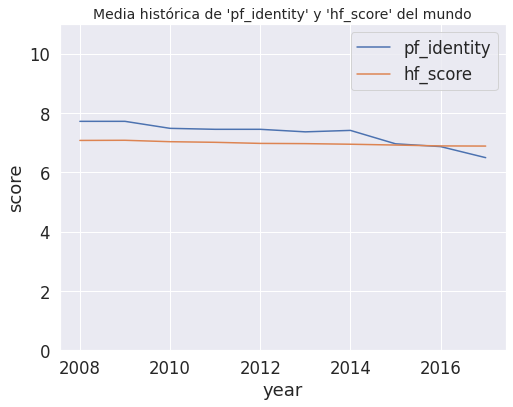

In [0]:
# MUNDO
df_mean_year = dataset.groupby(['year']).mean()[['pf_identity', 'hf_score']].reset_index()

fig, ax = plt.subplots(ncols=1, figsize=(8, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_mean_year, x='year', y='pf_identity', label='pf_identity' )
seaborn.lineplot(data=df_mean_year, x='year', y='hf_score', label='hf_score')
plt.legend()
ax.set_ylabel('score')
ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10
plt.title("Media histórica de 'pf_identity' y 'hf_score' del mundo", fontdict={'fontsize': 14})

plt.show()

Analizando la línea de tiempo de la variable _'pf_identity'_, es posible notar que existe una tendencia a nivel mundial a decrecer en estos valores desde el año 2014. Por otro lado, el promedio mundial año por año del indicador _'hf_score'_ se mantiene estable. Esto sucede a pesar de que el segundo indicador depende del primero. A partir de esto, podemos suponer que el peso relativo de _'pf_identity'_ es poco, en el cálculo de _'hf_score'_.

2.2 Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?

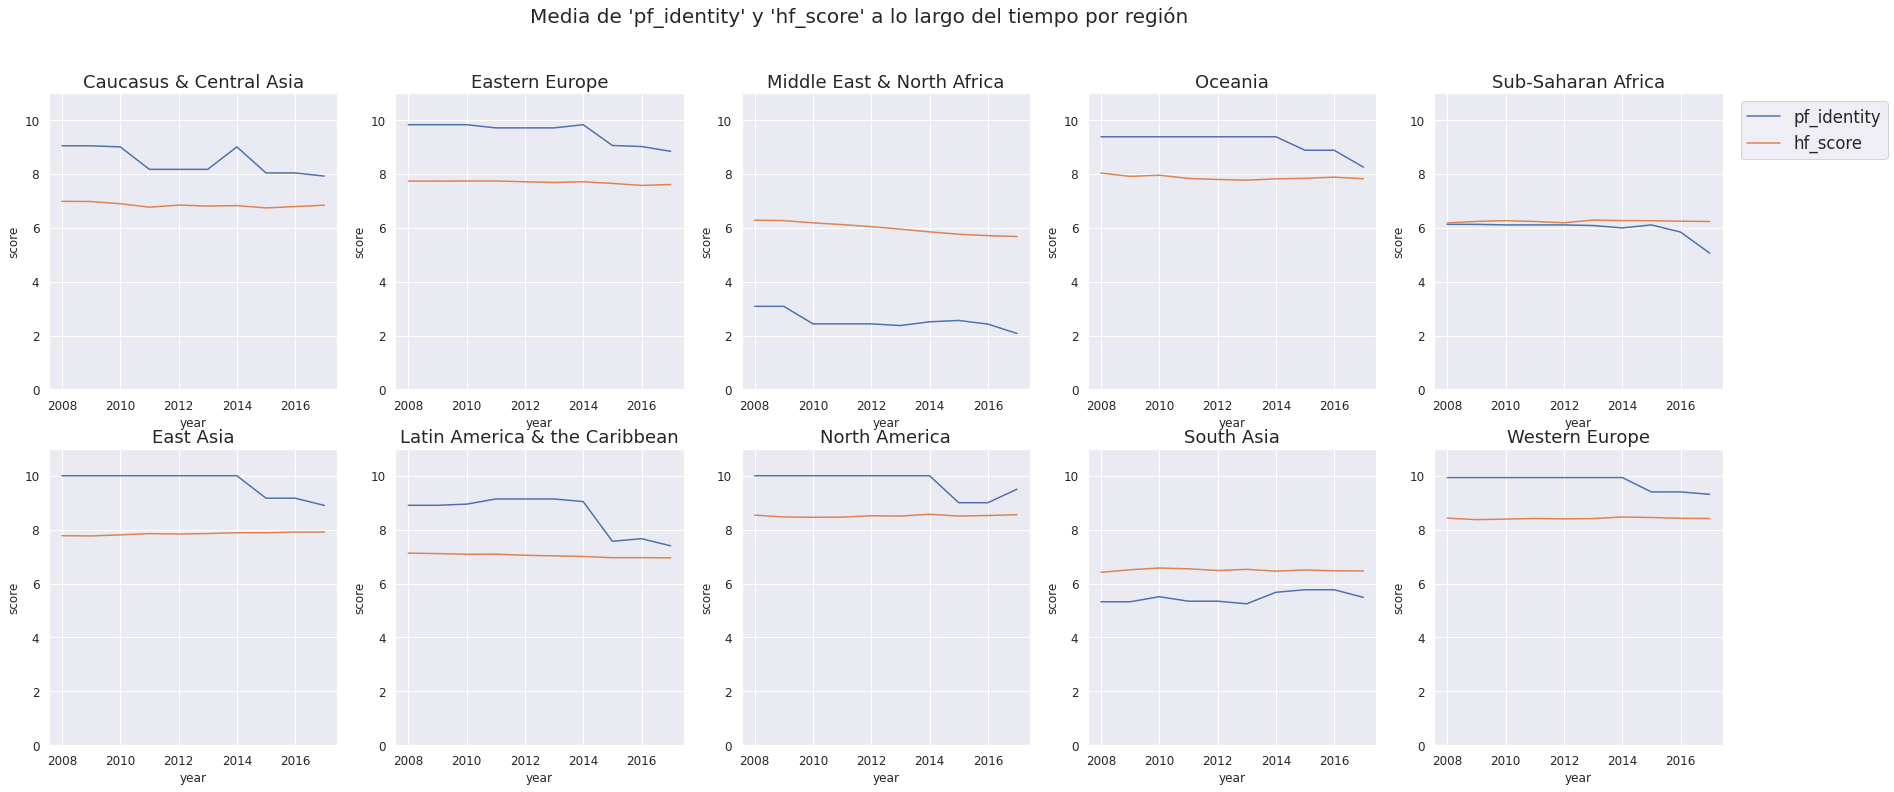

In [0]:
# REGIONES
df_mean_by_year_region = dataset.groupby(['region', 'year']).mean()[['pf_identity', 'hf_score']].reset_index()
regions = df_mean_by_year_region['region'].unique()

# GRAFICO
fig, axs = plt.subplots(2, 5, figsize=(30, 12))  # para plotear un gráfico al lado del otro

c = 0
r = 0
for reg in regions:
    axs[c,r].set_title(reg, )
    seaborn.lineplot(x='year', y='pf_identity', 
                     data=df_mean_by_year_region[df_mean_by_year_region['region']==reg], ax=axs[c,r], label='pf_identity', legend=False)
    seaborn.lineplot(x='year', y='hf_score', 
                     data=df_mean_by_year_region[df_mean_by_year_region['region']==reg], ax=axs[c,r], label='hf_score', legend=False)
    axs[c,r].set_ylabel('score', fontdict={'fontsize': 12})
    axs[c,r].set_xlabel('year', fontdict={'fontsize': 12})
    axs[c,r].tick_params(axis='both', which='major', labelsize=12)
    axs[c,r].set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10
    c += 1
    if (c == 2):
      c = 0
      r += 1

plt.legend(bbox_to_anchor=(1.6, 2.2))  # para mover la leyenda a la derecha
fig.suptitle("Media de 'pf_identity' y 'hf_score' a lo largo del tiempo por región", fontsize=20)
plt.show()

Si miramos _'pf_identity'_ por región vemos que el comportamiento no es similar entre regiones. En todas las regiones, exepto el Sur de Asia, hay una caída en este inidcador de 2014 a 2015. Excepto el Sur de Asia, todas las regiones tienen un valor menor de _'pf_identity'_ al final del periodo, lo que es consistente con que en la media mundial, veamos un descenso. Es importante notar que todas las regiones tienen comportamientos distntos, de los que la media mundial no da mayor información.

En el caso del _'hf_score'_ la diferencia de comportamientos por región también es muy variable. Pero en este caso hay regiones estables que oscilan año a año, otras que decrecen en este indicador y otras que crecen. Esta información no se refleja en la media mundial.

2.3 Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable pf_identity en la región. ¿Cómo seleccionaron los países relevantes a esa tendencia?

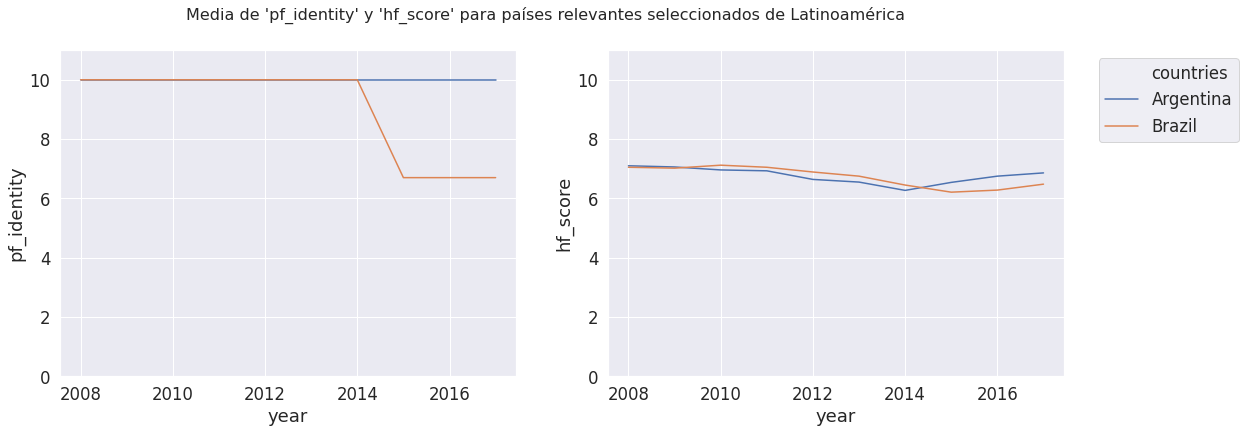

In [0]:
# PAISES RELEVANTES DE LATINOAMERICA, CONSIDERADOS POR SU MAYOR POBLACIÓN
selected_countries_2 = ['Argentina', 'Brazil']
df_selected_countries_2 = dataset[dataset['countries'].isin(selected_countries_2)]
df_mean_by_year_selected_countries_2 = df_selected_countries_2.groupby(['countries', 'year']).mean()[['pf_identity', 'hf_score']].reset_index()

## GRAFICO
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(x='year', y='pf_identity', hue='countries', data=df_mean_by_year_selected_countries_2, ax=axs[0], legend=False)
seaborn.lineplot(x='year', y='hf_score', hue='countries', data=df_mean_by_year_selected_countries_2, ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10
plt.legend(bbox_to_anchor=(1.4, 1))  # para mover la leyenda a la derecha
fig.suptitle("Media de 'pf_identity' y 'hf_score' para países relevantes seleccionados de Latinoamérica", fontsize=16)

plt.show()

Podemos ver en la línea de tiempo de la variable _'pf_identity'_ de Brasil la gran decaída que sufre dicha variable en el año 2014. La misma decaída puede observarse en la línea de tiempo de la variable para toda Latinoamérica y el Caribe, por lo que se puede decir que Brasil es un país representativo de la región, ya que sus evolución sigue la misma tendencia que el resto de la región latinoamericana. En cambio Argentina no sigue la tendencia de la región en este indicador.

En el indicacdor _'hf_score'_, Brasil y Argentina tienen tendencias muy similares y valores prácticamente superpuestos. Podemos suponer que en términos de libertad humana, que es lo que mide el indicador, son países similares. Además son representativos de la región, ya que siguen su tendencia y presentan valores similares.

2.4 Por curiosidad: graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

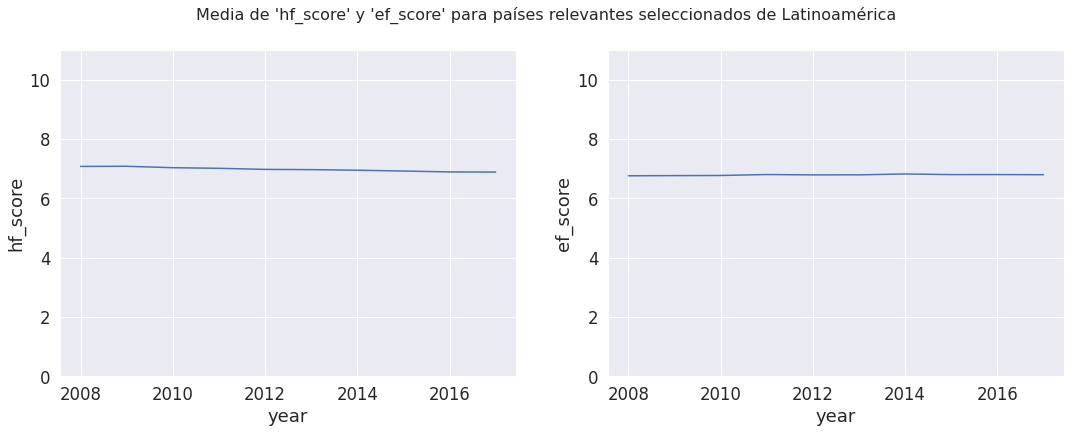

In [0]:
# MUNDO
# SOLO POR CURIOSIDAD, TENDENCIA DE HUMAN FREEDOM SCORE Y ECONOMIC FREEDOM SCORE

df_mean_year = dataset.groupby(['year']).mean()[['hf_score', 'ef_score']].reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(18, 6))  # para plotear un gráfico al lado del otro
seaborn.lineplot(data=df_mean_year, x='year', y='hf_score', ax=axs[0], legend=False),
seaborn.lineplot(data=df_mean_year, x='year', y='ef_score', ax=axs[1])
for ax in axs:
    ax.set_ylim(0, 11)  # eje y no puede ser menor a 0 ni mayor a 10
    
fig.suptitle("Media de 'hf_score' y 'ef_score' para países relevantes seleccionados de Latinoamérica", fontsize=16)

plt.show()

<font color='red'>**POSIBLE HIPÓTESIS**<font>


> Que las variables "hf_score" y "ef_score" a nivel mundial se hayan mantenido estables durante todos estos años, nos quiere decir que existen países con tendencias a aumentar sus libertades humanas y personales, y países con tendencias a disminuir dichas libertades, pero haciendo un promedio de todos los países del mundo estas tendencias cancelan sus efectos y la variable global se mantiene estable.
Cuando en alguna región del mundo hay una tendencia a aumentar la libertad económica y personal de sus habitantes, al mismo tiempo existe otra región que presenta una tendencia a disminuir la libertad de sus habitantes.






## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?


In [0]:
# Selección de países de América Latina
la_countries_filter =['Argentina', 'Mexico', 'Colombia', 'Argentina', 'Peru', 'Venezuela', 'Chile']  # Elección por cantidad de habitantes. Representan el 80% de la población de América Latina, aproximadamente.
df_la_filtered = dataset_la[dataset_la['countries'].isin(la_countries_filter)]
df_la_filtered_last_year = df_la_filtered[df_la_filtered['year'] == 2017]
df_world_last_year = dataset[dataset['year'] == 2017]

#### 3.a. Distribución de 'pf_identity' en el mundo y Latinoamérica y caribe
Visualmente, la variable 'pf_identity parace tener una distribución con asimetría negativa (o hacia la izquierda).

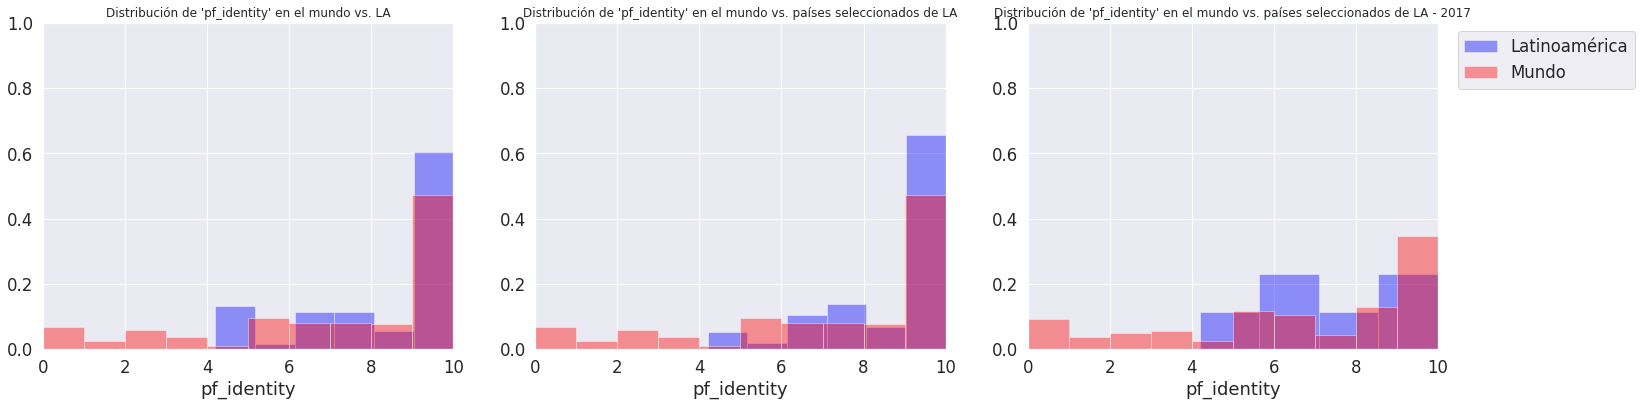

In [0]:
fig, axs = plt.subplots(ncols=3, figsize=(25, 6))  # para plotear un gráfico al lado del otro

# Histogramas de mundo y LA (plot 1), histogramas de mundo y países seleccionados de LA (plot 2), histogramas de mundo y países seleccionados de LA para 2017 (plot 3)
seaborn.distplot(dataset_la['pf_identity'], kde=False, bins=6, label='Latinoamérica', color='blue', norm_hist=True, ax=axs[0])
seaborn.distplot(dataset['pf_identity'], kde=False, bins=10, label='Mundo', color='red', norm_hist=True, ax=axs[0])
seaborn.distplot(df_la_filtered['pf_identity'], kde=False, bins=6, label='Latinoamérica', color='blue', norm_hist=True, ax=axs[1])
seaborn.distplot(dataset['pf_identity'], kde=False, bins=10, label='Mundo', color='red', norm_hist=True, ax=axs[1])
seaborn.distplot(df_la_filtered_last_year['pf_identity'], kde=False, bins=4, label='Latinoamérica', color='blue', norm_hist=True, ax=axs[2])
seaborn.distplot(df_world_last_year['pf_identity'], kde=False, bins=10, label='Mundo', color='red', norm_hist=True, ax=axs[2])

for ax in axs:
    ax.set_xlim(0, 10)  # eje x no puede ser menor a 0 ni mayor a 10
    ax.set_ylim(0, 1)  # eje y no puede ser menor a 0 ni mayor a 1
    ax.title.set_fontsize(12)
axs[0].title.set_text("Distribución de 'pf_identity' en el mundo vs. LA")
axs[1].title.set_text("Distribución de 'pf_identity' en el mundo vs. países seleccionados de LA")
axs[2].title.set_text("Distribución de 'pf_identity' en el mundo vs. países seleccionados de LA - 2017")
plt.legend(bbox_to_anchor=(1.5, 1))  # para mover la leyenda a la derecha

plt.show()

#### 3.b. Distribución de 'hf_score' en el mundo y Latinoamérica y caribe
Visualmente, la variable 'hfscore' parace tener distribución cercana a la Normal.

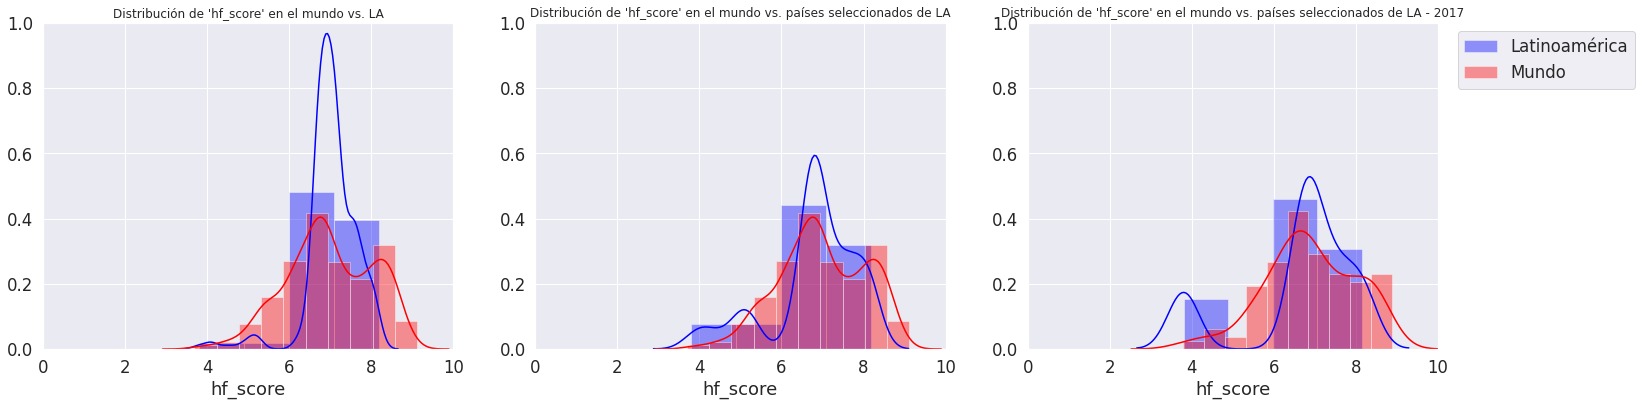

In [0]:
fig, axs = plt.subplots(ncols=3, figsize=(25, 6))  # para plotear un gráfico al lado del otro

# Histogramas de mundo y LA (plot 1), histogramas de mundo y países seleccionados de LA (plot 2), histogramas de mundo y países seleccionados de LA para 2017 (plot 3)
# Podemos plotear la función de densidad (kde=True) porque nunca se extiende fuera de 0, 10.
seaborn.distplot(dataset_la['hf_score'], kde=True, bins=4, label='Latinoamérica', color='blue', ax=axs[0])
seaborn.distplot(dataset['hf_score'], kde=True, bins=10, label='Mundo', color='red', ax=axs[0])
seaborn.distplot(df_la_filtered['hf_score'], kde=True, bins=4, label='Latinoamérica', color='blue', ax=axs[1])
seaborn.distplot(dataset['hf_score'], kde=True, bins=10, label='Mundo', color='red', ax=axs[1])
seaborn.distplot(df_la_filtered_last_year['hf_score'], kde=True, bins=4, label='Latinoamérica', color='blue', ax=axs[2])
seaborn.distplot(df_world_last_year['hf_score'], kde=True, bins=10, label='Mundo', color='red', ax=axs[2])

for ax in axs:
    ax.set_xlim(0, 10)  # eje x no puede ser menor a 0 ni mayor a 10
    ax.set_ylim(0, 1)  # eje y no puede ser menor a 0 ni mayor a 1
    ax.title.set_fontsize(12)
axs[0].title.set_text("Distribución de 'hf_score' en el mundo vs. LA")
axs[1].title.set_text("Distribución de 'hf_score' en el mundo vs. países seleccionados de LA")
axs[2].title.set_text("Distribución de 'hf_score' en el mundo vs. países seleccionados de LA - 2017")
plt.legend(bbox_to_anchor=(1.5, 1))  # para mover la leyenda a la derecha

plt.show()

#### 3.c ¿Es correcto tomar todos los valores disponibles de Latinoamérica y el Caribe para diagramar estos gráficos?
Dependiendo de los países elegidos de Latinoamérica y el Caribe, la distribución de la totalidad de la región puede ser muy similar o no respecto al subconjunto de países seleccionados. Sin embargo, no parece correcto tomar todos los países de la región para estimar su distribución, ya que al hacer eso se estaría ponderando a cada país por igual sin tener en cuenta otras variables como cantidad de habitantes, PBI, entre otros. Además, se está realizando la distribución de todos los años juntos, cuando, quizás, sería mejor tomar sólo el último año.

## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.

#### 4.1 Pairplot de variables 'pf_identity', 'pf_score' y 'hf_score'

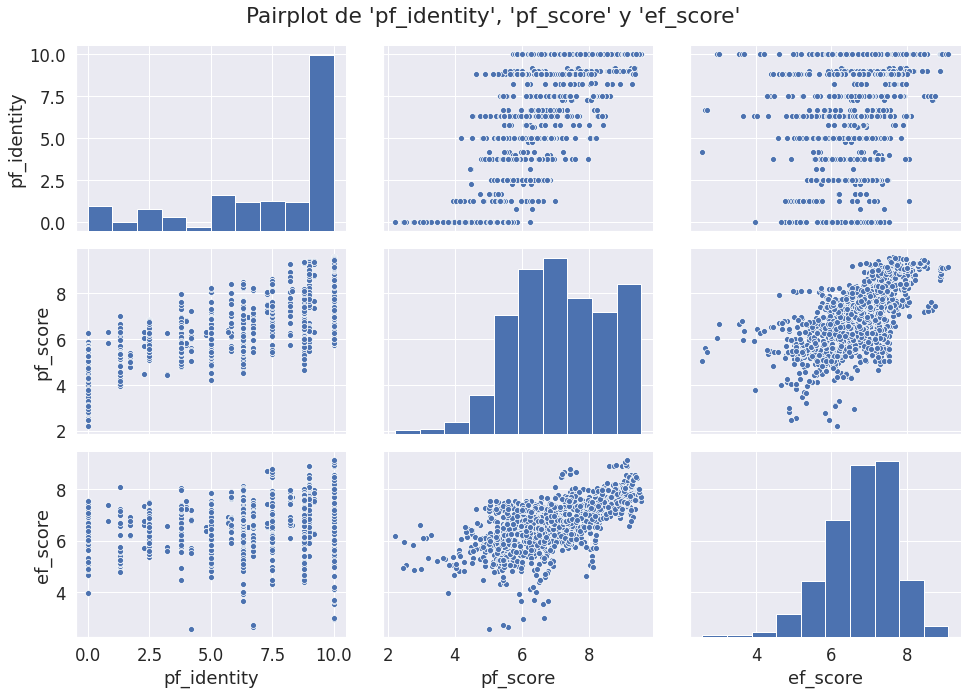

In [0]:
seaborn.pairplot(data=dataset, vars=["pf_identity", "pf_score", "ef_score"], height=3, aspect=1.5)
plt.suptitle("Pairplot de 'pf_identity', 'pf_score' y 'ef_score'", y=1.05)

plt.show()

Observando el pairplot notamos que, contrario a lo que esperábamos, las variables pf_score y pf_identity no parecieran ser las más correlacionadas. Éstas serían pf_score y ef_score, que tienen una correlación positiva. Sin embargo, considerando que pf_score contiene a pf_identity y observando que los gráficos en los que participa pf_identity no son tan claros es que creemos que el pairplot no es la mejor forma para ver la correlación de esa variable. Al intentar analizar el porqué de esta conclusión es que pensamos que podría deberse al hecho de que la variable pf_identity es, en la práctica, discreta.

#### 4.2 Correlaciones de a 2 variables

 Los siguientes gráficos son para ver la correlación de pf_identity con ef_score y pf_score. En ellos podemos observar una relación monotónica entre las variables, lo que indicaría una correlación positiva entre pf_identity y pf_score, lo cual no se visualizaba mediante el gráfico pairplot.

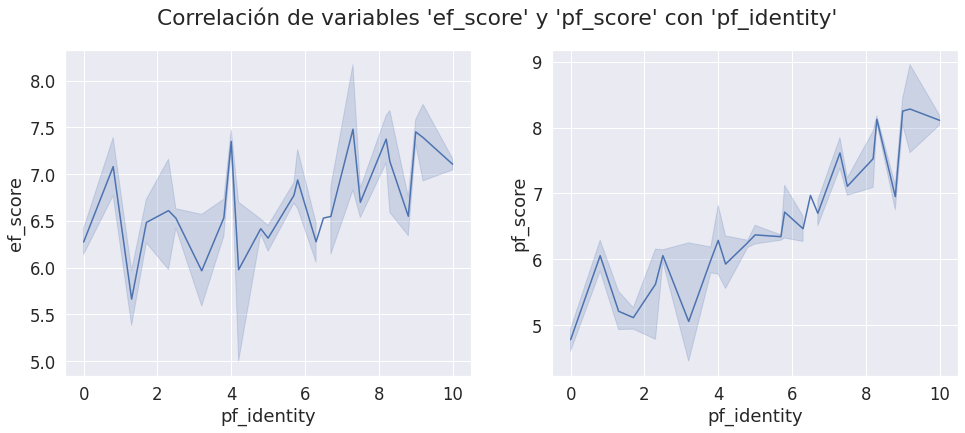

In [0]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))

seaborn.lineplot(data= dataset, x='pf_identity', y= 'ef_score',ax=axs[0])
seaborn.lineplot(data= dataset, x='pf_identity', y= 'pf_score', ax=axs[1])
plt.suptitle("Correlación de variables 'ef_score' y 'pf_score' con 'pf_identity'")

plt.show()

#### 4.3 Conversión de variables en categóricas

Dado que teníamos tres categorías: "low", "medium" y "high", decidimos usar terciles. En la única variable que tuvimos inconvenientes fue en pf_identity, porque está muy concentrada en el 10 por lo que tuvimos que sacarle la posibilidad al 10 de caer en el segundo tercil.

In [0]:
pf_identity_1 = dataset['pf_identity'].min()
pf_identity_2 = numpy.quantile(dataset.pf_identity.dropna(),.33)
pf_identity_3 = numpy.quantile(dataset.pf_identity.dropna(),.66)
pf_identity_4 = numpy.quantile(dataset.pf_identity.dropna(),1) 

dataset['pf_identity_segment'] = pandas.cut(dataset.pf_identity, bins=[pf_identity_1 , pf_identity_2, pf_identity_3 - 0.1 , pf_identity_4], labels=['low','medium','high'])

pf_score_1 = dataset['pf_score'].min()
pf_score_2 = numpy.quantile(dataset.pf_score.dropna(),.33)
pf_score_3 = numpy.quantile(dataset.pf_score.dropna(),.66) 
pf_score_4 = numpy.quantile(dataset.pf_score.dropna(),1)

dataset['pf_score_segment'] = pandas.cut(dataset.pf_score, bins=[pf_score_1 ,pf_score_2,pf_score_3,pf_score_4], labels=['low','medium','high'])

ef_score_1 = dataset['ef_score'].min()
ef_score_2 = numpy.quantile(dataset.ef_score.dropna(),.33)
ef_score_3 = numpy.quantile(dataset.ef_score.dropna(),.66) 
ef_score_4 = numpy.quantile(dataset.ef_score.dropna(),1)

dataset['ef_score_segment'] = pandas.cut(dataset.ef_score, bins=[ef_score_1,ef_score_2,ef_score_3,ef_score_4], labels=['low','medium','high'])



In [0]:
dataset.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank,pf_identity_segment,pf_score_segment,ef_score_segment
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0,low,high,high
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0,NaN,low,low
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0,low,low,low
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0,high,high,low
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0,medium,medium,high


#### 4.4 Correlación entre variables categóricas

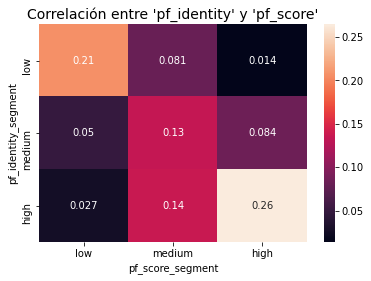

In [0]:
seaborn.heatmap(pandas.crosstab(dataset.pf_identity_segment, dataset.pf_score_segment, normalize=True), annot=True)
plt.title("Correlación entre 'pf_identity' y 'pf_score'", fontdict={'fontsize': 14})

plt.show()

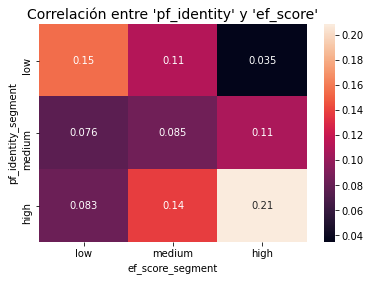

In [0]:
seaborn.heatmap(pandas.crosstab(dataset.pf_identity_segment, dataset.ef_score_segment, normalize=True), annot=True) 
plt.title("Correlación entre 'pf_identity' y 'ef_score'", fontdict={'fontsize': 14})

plt.show()

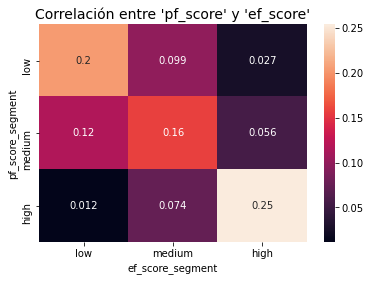

In [0]:
seaborn.heatmap(pandas.crosstab(dataset.pf_score_segment, dataset.ef_score_segment, normalize=True), annot=True)
plt.title("Correlación entre 'pf_score' y 'ef_score'", fontdict={'fontsize': 14})

plt.show()

Estos heatmaps se pueden interpretar como probabilidades conjuntas. Por ejemplo, si observamos el primer gráfico tenemos que la probabilidad de que un país puntúe "high" en pf_score y en pf_identity es de 0,26. Esa misma idea se puede repetir cruzando todas las categorías de todas las variables.

Ahora bien, en los tres gráficos resalta que las probabilidades más altas están cuando se cruzan las categorías "high" con "high" y "low" con "low". Es decir, la probabilidad de que los países que puntúan bien en una de las variables, puntúen también bien en cualquiera de las otras dos variables es alta. Análogamente sucede cuando pensamos qué sucede con un país que puntúa mal en alguna de las categorías.

Lo contrario sucede cuando cruzamos categorías opuestas: low con high. En este caso, observamos que las probabilidades son bajas. Es poco probable que un país que tiene un buen puntaje en una de la variables, tenga un mal puntaje en cualquiera de las otras dos.

Esto nos lleva a pensar que existe una fuerte correlación entre estas variables. Es muy probable que los países caigan en la misma categoría para las tres variables. Es decir, a quienes les va bien en una variable, es probable que les vaya bien en todas las variables y a quienes les va mal en una variable, tienen más probabilidades de que les vaya también mal en las otras dos.

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

In [0]:
df_world_last_year = dataset[dataset['year'] == 2017]

la_last_year       = df_world_last_year[df_world_last_year['region'] == 'Latin America & the Caribbean' ]
cca_last_year      = df_world_last_year[df_world_last_year['region'] == 'Caucasus & Central Asia' ]

In [0]:
df_world_last_year = dataset[dataset['year'] == 2017]

regions = ['Latin America & the Caribbean','North America','Sub-Saharan Africa','Oceania',
           'Western Europe','Eastern Europe','Caucasus & Central Asia','South Asia','East Asia']

k_tests = []

x     = df_world_last_year['pf_identity']
mu    = numpy.mean( x )
std   = numpy.std( x )
n     = len( x )
#print ( mu, std, n)
test  = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
s, p  = ss.kstest(test,'norm')
kde    = ss.gaussian_kde(x)
s1, p1 = ss.kstest(x,kde)
#print( 'World', s, p )

k_tests.append( {
        'region': 'World',
        'Estadístico    (Distribución Normal)': s,
        'p-valor': p,
        'Estadístico    (Dist. Gauss. KDE)': s1,
        "p-valor'": p1,
        'Media': mu,
        'Desviación estándar': std,
        'N': n
} )

for reg in regions:
    w     = df_world_last_year[df_world_last_year['region'] == reg]
    x     = w['pf_identity']
    mu    = numpy.mean( x )
    std   = numpy.std( x )
    n     = len( x )
#    print ( mu, std, n)
    test  = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
    s, p  = ss.kstest(test,'norm')
    kde    = ss.gaussian_kde(x)
    s1, p1 = ss.kstest(x,kde)
    #print( reg, s, p )

    k_tests.append( {
        'region': reg,
        'Estadístico    (Distribución Normal)': s,
        'p-valor': p,
        'Estadístico    (Dist. Gauss. KDE)': s1,
        "p-valor'": p1,
        'Media': mu,
        'Desviación estándar': std,
        'N': n
    } )
    
    #k_tests.append(( reg,s,pv,mu,std,n))
k_tests = pandas.DataFrame(k_tests)
k_tests

,region,Estadístico (Distribución Normal),p-valor,Estadístico (Dist. Gauss. KDE),p-valor',Media,Desviación estándar,N
0,World,0.465123,1.259253e-32,0.880162,1.359621e-149,6.496914,3.144158,162
1,Latin America & the Caribbean,0.397160,3.275881e-04,0.873589,9.043140e-24,7.400000,1.955859,26
2,North America,0.260250,9.992452e-01,0.589353,3.372626e-01,9.500000,0.500000,2
3,Sub-Saharan Africa,0.397557,1.684285e-06,0.948720,1.314996e-54,5.057143,2.937130,42
4,Oceania,0.327414,7.037758e-01,0.840500,1.294418e-03,8.250000,1.920286,4
5,Western Europe,0.388994,5.795713e-03,0.723287,4.325564e-10,9.311111,0.525874,18
6,Eastern Europe,0.393625,1.388874e-03,0.795803,1.938326e-15,8.836364,0.884999,22
7,Caucasus & Central Asia,0.279936,6.612323e-01,0.867805,1.067393e-05,7.916667,1.458786,6
8,South Asia,0.373413,1.230401e-02,0.914442,1.410896e-18,5.488235,2.788608,17
9,East Asia,0.319246,4.801063e-01,0.814354,8.189787e-05,8.900000,0.608276,6


El test de Kolmogorov-Smirnof mide qué tan bien encaja una distribución propuesta para representar un conjunto de datos propuestos. Para los datos genera una función de distribución acumulada que consiste en un _escalón_ de igual altura por dato. Luego, por cada dato se calcula la diferencia de la función distribución acumulada _escalón_ con la distribución acumulada propuesta. El estadístico devuelve la mayor de estas diferencias, por estar definido 0 < s < 1, y cuanto menor sea más se parecen las distribuciones (si fuesen _exactamente_ iguales, entonces s=0).

En la tabla anterior se muestran los tests de Kolmogorov-Smirnof para los datos del indicador _'pf_identity'_, en el mundo y en sus regiones. Las dos columnas siguientes a la región muestran el valor del estadístico del test y el p-valor para los datos normalizados y comparados con una normal de media 0 y desviación estándar 1. Las 2 columnas siguientes muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución ajustada con kernels gausianos (Gaussian kernel density estimate). Luego están la media, la desviación estandar y la cantidad datos para cada caso.

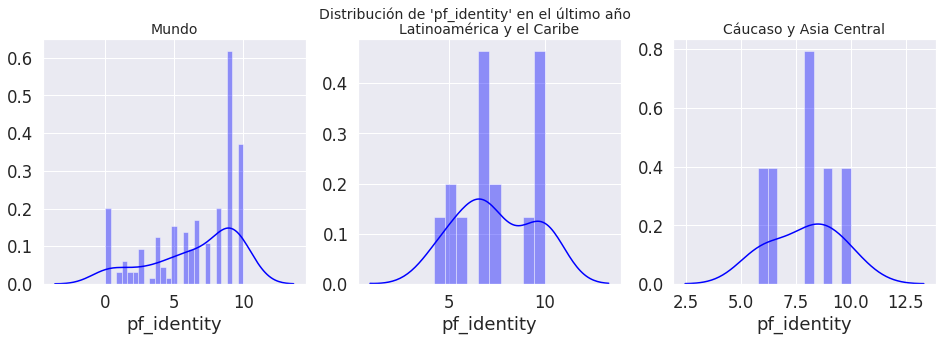

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))

seaborn.distplot(df_world_last_year['pf_identity'], kde=True, bins=25, label='Mundo', color='blue', norm_hist=True, ax=axs[0])
seaborn.distplot(la_last_year['pf_identity'], kde=True, bins=10, label='Latinoamérica', color='blue', norm_hist=True, ax=axs[1])
seaborn.distplot(cca_last_year['pf_identity'], kde=True, bins=10, label='Cáusaso y Asia Central', color='blue', norm_hist=True, ax=axs[2])

plt.suptitle("Distribución de 'pf_identity' en el último año", fontsize=14)
axs[0].title.set_text("Mundo")
axs[0].title.set_fontsize(14)
axs[1].title.set_text("Latinoamérica y el Caribe")
axs[1].title.set_fontsize(14)
axs[2].title.set_text("Cáucaso y Asia Central")
axs[2].title.set_fontsize(14)

In [0]:
k_tests_hf_score = []

x     = df_world_last_year['hf_score']
mu    = numpy.mean( x )
std   = numpy.std( x )
n     = len( x )
#print ( mu, std, n)
test  = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
s, p  = scipy.stats.kstest(test,'norm')
kde    = scipy.stats.gaussian_kde(x)
s1, p1 = scipy.stats.kstest(x,kde)
#print( 'World', s, p )

k_tests_hf_score.append( {
        'region': 'World',
        'Estadístico    (Distribución Normal)': s,
        'p-valor': p,
        'Estadístico    (Dist. Gauss. KDE)': s1,
        "p-valor'": p1,
        'Media': mu,
        'Desviación estándar': std,
        'N': n
} )

for reg in regions:
    w      = df_world_last_year[df_world_last_year['region'] == reg]
    x      = w['hf_score']
    mu     = numpy.mean( x )
    std    = numpy.std( x )
    n      = len( x )
#    print ( mu, std, n)
    test   = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
    s, p   = scipy.stats.kstest(test,'norm')
    kde    = scipy.stats.gaussian_kde(x)
    s1, p1 = scipy.stats.kstest(x,kde)
    #print( reg, s, p )

    k_tests_hf_score.append( {
        'region': reg,
        'Estadístico    (Distribución Normal)': s,
        'p-valor': p,
        'Estadístico    (Dist. Gauss. KDE)': s1,
        "p-valor'": p1,
        'Media': mu,
        'Desviación estándar': std,
        'N': n
    } )
    
    #k_tests.append(( reg,s,pv,mu,std,n))
k_tests_hf_score = pandas.DataFrame(k_tests_hf_score)
k_tests = pandas.DataFrame(k_tests)
k_tests_hf_score

,region,Estadístico (Distribución Normal),p-valor,Estadístico (Dist. Gauss. KDE),p-valor',Media,Desviación estándar,N
0,World,0.443465,1.506728e-29,0.893094,1.095483e-157,6.887963,1.100704,162
1,Latin America & the Caribbean,0.412905,1.587644e-04,0.856874,2.376573e-22,6.951538,0.756707,26
2,North America,0.260250,9.992452e-01,2.161302,0.000000e+00,8.555000,0.095000,2
3,Sub-Saharan Africa,0.385795,3.895011e-06,0.878819,6.634798e-39,6.231429,0.662569,42
4,Oceania,0.289693,8.903455e-01,0.749919,7.822671e-03,7.817500,0.958446,4
5,Western Europe,0.374014,9.062324e-03,1.723394,0.000000e+00,8.412778,0.195528,18
6,Eastern Europe,0.382676,2.085147e-03,0.670544,2.741165e-10,7.605000,0.610758,22
7,Caucasus & Central Asia,0.291554,6.039910e-01,0.684889,2.550394e-03,6.838333,0.670682,6
8,South Asia,0.342601,2.764355e-02,0.932758,2.349419e-20,6.467647,0.614841,17
9,East Asia,0.334029,4.232461e-01,0.657027,4.598565e-03,7.911667,0.855247,6


En la tabla anterior se muestran los tests de Kolmogorov-Smirnof para los datos del indicador _'hf_score'_, en el mundo y en sus regiones. Las dos columnas siguientes a la región muestran el valor del estadístico del test y el p-valor del para los datos normalizados y comparados con una normal de media 0 y desviación estándar 1. Las dos columnas siguientes muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución ajustada con kernels gausianos (Gaussian kernel density estimate). Luego, la media, la desviación estandar y la cantidad datos para cada caso.

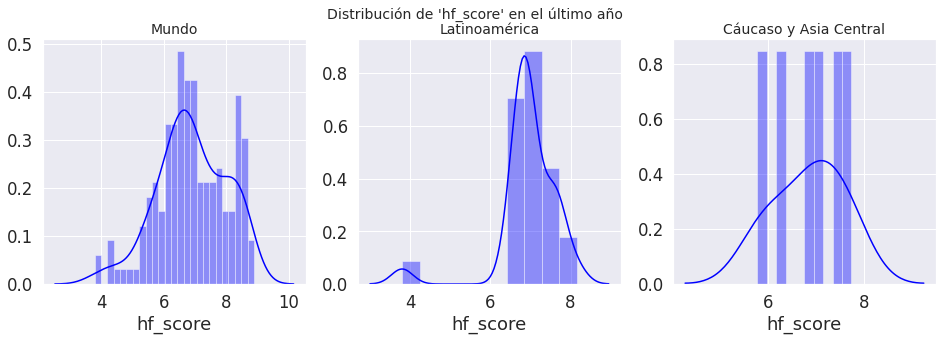

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4.5))

seaborn.distplot(df_world_last_year['hf_score'], kde=True, bins=25, label='Mundo', color='blue', norm_hist=True, ax=axs[0])
seaborn.distplot(la_last_year['hf_score'], kde=True, bins=10, label='Latino América', color='blue', norm_hist=True, ax=axs[1])
seaborn.distplot(cca_last_year['hf_score'], kde=True, bins=10, label='Causaso y Asia Central', color='blue', norm_hist=True, ax=axs[2])
plt.suptitle("Distribución de 'hf_score' en el último año", fontsize=14)
axs[0].title.set_text("Mundo")
axs[0].title.set_fontsize(14)
axs[1].title.set_text("Latinoamérica")
axs[1].title.set_fontsize(14)
axs[2].title.set_text("Cáucaso y Asia Central")
axs[2].title.set_fontsize(14)

In [0]:
k_tests = []

df_world = dataset[dataset['year'] == 2017]

for col in df_world.columns:
    if col not in ['year', 'ISO_code', 'countries', 'region','pf_identity_segment','pf_score_segment',
                   'ef_score_segment','pf_identity_legal','pf_identity_divorce','pf_rank','ef_rank','hf_rank']:
        x     = df_world[col]
        mu    = numpy.mean( x )
        std   = numpy.std( x )
        n     = len( x )
        test  = [ (y - mu)/(std*numpy.sqrt(n)) for y in x ]
        s, p  = scipy.stats.kstest(test,'norm')
        s1, p1 = scipy.stats.kstest(df_world[col],scipy.stats.gaussian_kde(df_world[col]))
        #print (col, mu, std, n, s, p)
        k_tests.append( {
            'category':col,
            'Estadístico    (Distribución Normal)': s,
            'p-valor': p,
            'Estadístico    (Dist. Gauss. KDE)': s1,
            "p-valor'": p1,
            'Media': mu,
            'Desviación estándar': std,
            'N': n
        } )
        
k_tests = pandas.DataFrame(k_tests)
k_tests

,category,Estadístico (Distribución Normal),p-valor,Estadístico (Dist. Gauss. KDE),p-valor',Media,Desviación estándar,N
0,pf_identity_sex_male,0.477617,1.740628e-34,0.845648,2.140600e-131,6.635802,4.708485,162
1,pf_identity_sex_female,0.483325,2.345720e-35,0.792193,3.466326e-109,7.808642,4.117913,162
2,pf_identity_sex,0.478878,1.120822e-34,0.823507,1.602678e-121,7.222222,4.120110,162
3,pf_identity,0.465123,1.259253e-32,0.880162,1.359621e-149,6.496914,3.144158,162
4,pf_score,0.446683,5.397538e-30,0.895361,3.348719e-159,6.976852,1.449555,162
5,ef_score,0.430577,8.404260e-28,0.977150,2.766099e-266,6.799074,0.930856,162
6,hf_score,0.443465,1.506728e-29,0.893094,1.095483e-157,6.887963,1.100704,162


En la tabla anterior se muestran los tests de Kolmogorov-Smirnof para las datos de todo el mundo de los diferentes indicadores. Las dos columnas siguientes a la región muestran el valor del estadístico del test y el p-valor del para los datos normalizados y comparados con una normal de media 0 y desviación estándar 1. Las 2 columnas siguientes muestran el estadístico y el p-valor cuando se realiza el test a los datos con una distribución ajustada con kernels gausianos (Gaussian kernel density estimate). Luego la media, la desviación estandar y la cantidad datos para cada caso.

En todos los casos el estadístico se encuentra entre 0.3 y 0.5, lo que podría ser correcto para muestras normales de alrededor de 10 datos, como se muestra en la tabla siguiente en los gráficos siguientes, donde se tomaron muestras de diferentes tamaños de números aleatorios con distribución normal y se compararon con el test. En el caso de los ajustes con kernels gausianos (scipy.stats.gausssian_kde), el estadístico dio valores mayores, por lo que no parecen ser mejores distribuciones que la normal para ajustar estos datos.

Luego si miramos el p-valor de los tests, en todos es muy chico (en la mayoría de los casos $<10^{-4}$, mientras que para datos con districución normal en ningún caso obtuve uno menor a 0.2). Entonces, podemos concluir que los datos que hemos probado no siguen una distribución normal o una ajustada con kernels gausianos; las distribuciones probadas. Los p valores más altos encontrados fueron en algunos casos con pocos datos, como los indicadores _'pf_identity'_ y _'hf_score'_ en el Cáucaso y Asia central, región con sólo 6 países.

In [0]:
x = numpy.random.normal(0,1,10)
y = numpy.random.normal(0,1,100)
z = numpy.random.normal(0,1,1000)
k = numpy.random.normal(0,1,10000)
sx, px   = scipy.stats.kstest(x,'norm')
sy, py   = scipy.stats.kstest(y,'norm')
sz, pz   = scipy.stats.kstest(z,'norm')
sk, pk   = scipy.stats.kstest(k,'norm')
tests = []
tests.append( { 'N': 10, 'Estadístico': sx, 'p-valor': px } )
tests.append( { 'N': 100, 'Estadístico': sy, 'p-valor': py } )
tests.append( { 'N': 1000, 'Estadístico': sz, 'p-valor': pz } )
tests.append( { 'N': 10000, 'Estadístico': sk, 'p-valor': pk } )
tests = pandas.DataFrame(tests)
tests

,N,Estadístico,p-valor
0,10,0.272508,0.379831
1,100,0.073792,0.641459
2,1000,0.030700,0.297504
3,10000,0.004957,0.966628


Para mostrar utilidad del test de Kolmogorov-Smirnof, en lo que sigue se muestran los resultados de analizar distribuciones normales generadas con numeros aleatorios de la computadora de diferentes tamaños (10, 100, 1000, 10000). Para distintas pruebas se observa que el p-valor es superior a 0.1 pero aún para N=1000 flutúa bastante de muestra a muestra. En todos los casos el estadístico de test da valores pequeños, que muestra que los datos difieren muy poco de la distribución con la que los esta comparando, este caso normal de media 0 y desviación 1.

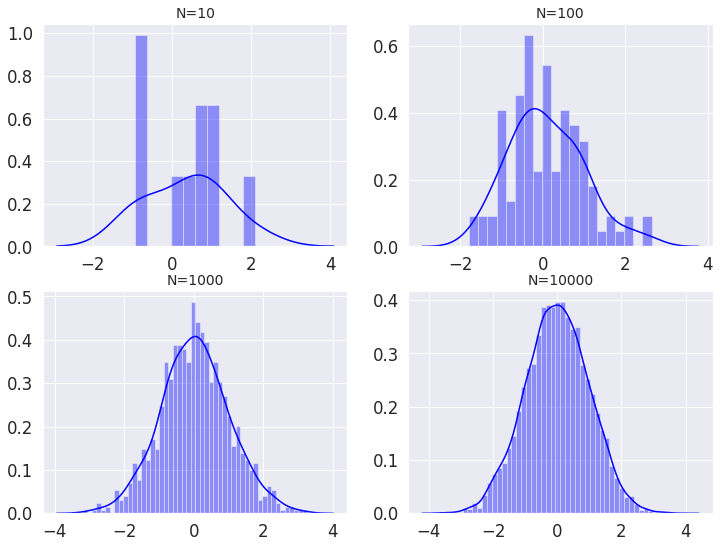

In [0]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

seaborn.distplot(x, kde=True, bins=10, label='N=10', color='blue', norm_hist=True, ax=axs[0,0])
seaborn.distplot(y, kde=True, bins=20, label='N=100', color='blue', norm_hist=True, ax=axs[0,1])
seaborn.distplot(z, kde=True, bins=50, label='N=1000', color='blue', norm_hist=True, ax=axs[1,0])
seaborn.distplot(k, kde=True, bins=50, label='N=10000', color='blue', norm_hist=True, ax=axs[1,1])

axs[0,0].title.set_text("N=10")
axs[0,0].title.set_fontsize(14)
axs[0,1].title.set_text("N=100")
axs[0,1].title.set_fontsize(14)
axs[1,0].title.set_text("N=1000")
axs[1,0].title.set_fontsize(14)
axs[1,1].title.set_text("N=10000")
axs[1,1].title.set_fontsize(14)

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?

#### 2.4.3 Coeficientes de correlación entre variables

Para ver que correlación aplicar entre las variables, se pueden obtener los gráficos de las distribuciones de las mismas.


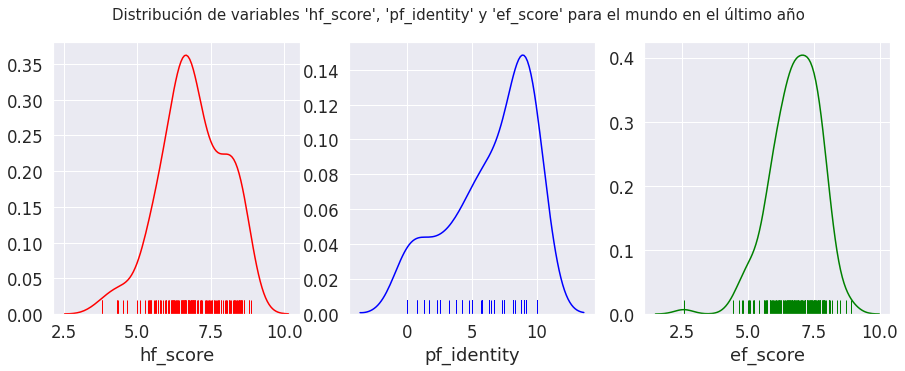

In [0]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
seaborn.distplot(df_world_last_year['hf_score'], hist=False, rug=True, color='red', ax=axs[0])
seaborn.distplot(df_world_last_year['pf_identity'], hist=False, rug=True, color='blue', ax=axs[1])
seaborn.distplot(df_world_last_year['ef_score'], hist=False, rug=True, color='green', ax=axs[2])
plt.suptitle("Distribución de variables 'hf_score', 'pf_identity' y 'ef_score' para el mundo en el último año", fontsize=15)

plt.show()

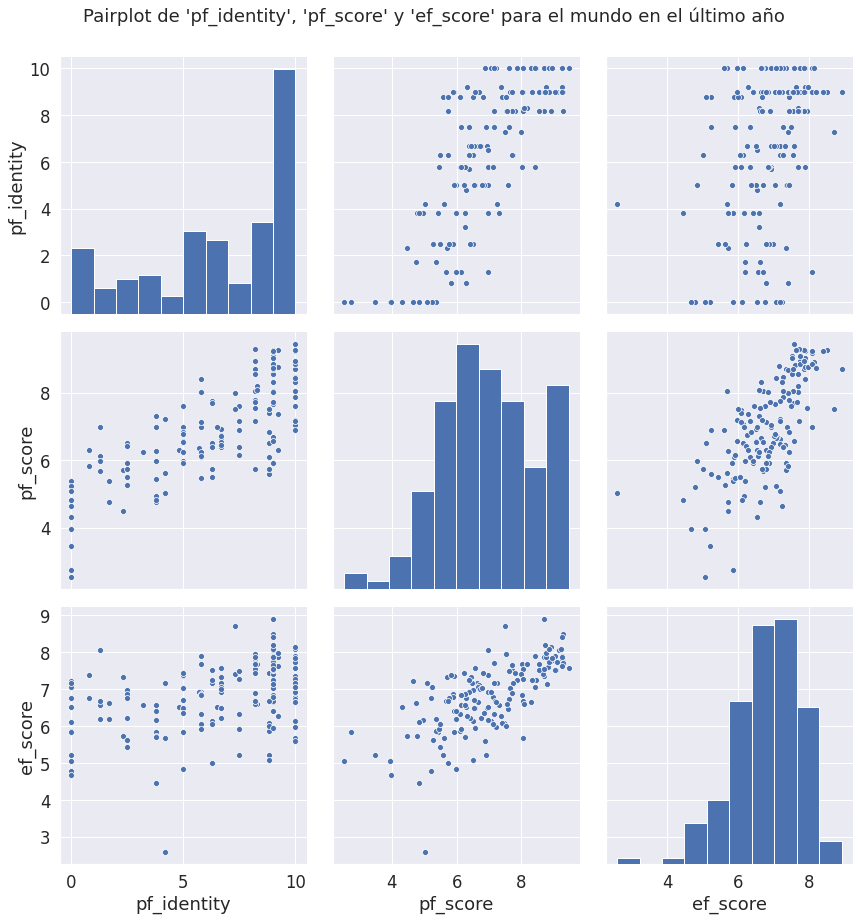

In [0]:
seaborn.pairplot(data=df_world_last_year,vars=['pf_identity','pf_score','ef_score'], height= 4)
plt.suptitle("Pairplot de 'pf_identity', 'pf_score' y 'ef_score' para el mundo en el último año", y=1.05, fontsize=18)

plt.show()

Analizando estas gráficas vemos que existe una relación monotónica positiva entre pares de variables (cuando una crece la otra también lo hace), con lo cual se podría decir, a priori, que existe alguna correlación entre las mismas.

Para poder conocer esta correlación podemos aplicar diferentes métodos:

##### Método Pearson
Este método determina si hay una correlación lineal entre las variables:

In [0]:
columnas = ['pf_identity','pf_score','ef_score']
df_world_last_year[columnas].corr(method='pearson')

,pf_identity,pf_score,ef_score
pf_identity,1.000000,0.771508,0.413276
pf_score,0.771508,1.000000,0.695424
ef_score,0.413276,0.695424,1.000000


Como vemos, entre "pf_identity" y "pf_score" es alta la correlación lineal pero entre "pf_identity" y "ef_score" es baja. 
También podemos decir que entre "pf_score" y "ef_score" es alta la correlación lineal.

##### Método Spearman
Esta correlación, a diferencia de Pearson, asume que las variables no están distribuidas siguiendo una distribución normal. Sí asume monotonicidad entre las variables.

In [0]:
df_world_last_year[columnas].corr(method='spearman')

,pf_identity,pf_score,ef_score
pf_identity,1.000000,0.758608,0.422218
pf_score,0.758608,1.000000,0.710746
ef_score,0.422218,0.710746,1.000000


Como podemos ver, se sigue manteniendo el patrón de correlación observado con el método anterior. 

##### Método de Kendall

In [0]:
columnas = ['pf_identity','pf_score','ef_score']
df_world_last_year[columnas].corr(method='kendall')

,pf_identity,pf_score,ef_score
pf_identity,1.000000,0.580022,0.301084
pf_score,0.580022,1.000000,0.517322
ef_score,0.301084,0.517322,1.000000


Este método no sería adecuado para este tipo de datos por no estar rankeados. 

#### Pregunta extra

La pregunta que surge es si esta correlación se mantiene con el tiempo o fue sólo particular para el año 2017. 

Para responder esto podemos, ver las correlaciones a medida que transcurre el tiempo.

In [0]:
years =[2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
corr_pfIdentity_pfScore = []
corr_pfIdentity_efScore = []
corr_efScore_pfScore = []
for year in years:
    df_world_year = df_clean[df_clean['year'] == year]
    corr_pfIdentity_pfScore.append(ss.pearsonr(df_world_year['pf_identity'], df_world_year['pf_score'])[0])
    corr_pfIdentity_efScore.append(ss.pearsonr(df_world_year['pf_identity'], df_world_year['ef_score'])[0])
    corr_efScore_pfScore.append(ss.pearsonr(df_world_year['pf_score'], df_world_year['ef_score'])[0])
                                   
corr_list = list(zip(corr_pfIdentity_pfScore,corr_pfIdentity_efScore,corr_efScore_pfScore))
datosCorr = pandas.DataFrame(corr_list, columns=['pfI_pfS', 'pfI_efS','pfS_efS'], index=years)
datosCorr    

,pfI_pfS,pfI_efS,pfS_efS
2008,0.781168,0.391507,0.696493
2009,0.772022,0.391645,0.690791
2010,0.764521,0.366135,0.688541
2011,0.752743,0.390636,0.689933
2012,0.747536,0.409765,0.708612
2013,0.749003,0.395665,0.667106
2014,0.744033,0.370095,0.677349
2015,0.753717,0.383551,0.690028
2016,0.755870,0.386218,0.683679
2017,0.771508,0.413276,0.695424


En forma gráfica:

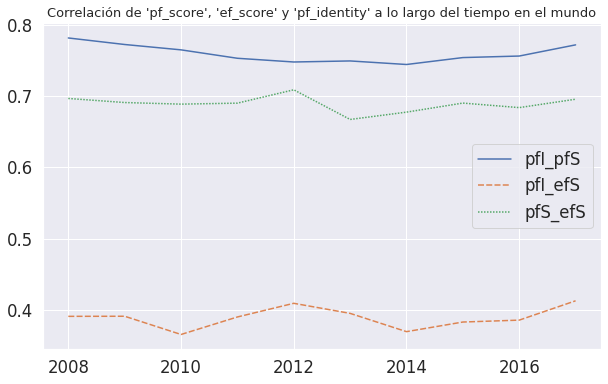

In [0]:
plt.figure(figsize=(10,6))
seaborn.lineplot(data=datosCorr)
plt.title("Correlación de 'pf_score', 'ef_score' y 'pf_identity' a lo largo del tiempo en el mundo", fontsize=13)

plt.show()

Como podemos ver, los coeficientes de correlación se mantienen con muy poca variación durante el transcurso de los años.

### 2.4.4 Opcional

Para ver cómo se correlacionan las variables con las regiones podemos ver primeramente cómo se distribuyen las mismas. 

Para ello, podemos gráficar las distribuciones e identificarlas por región.

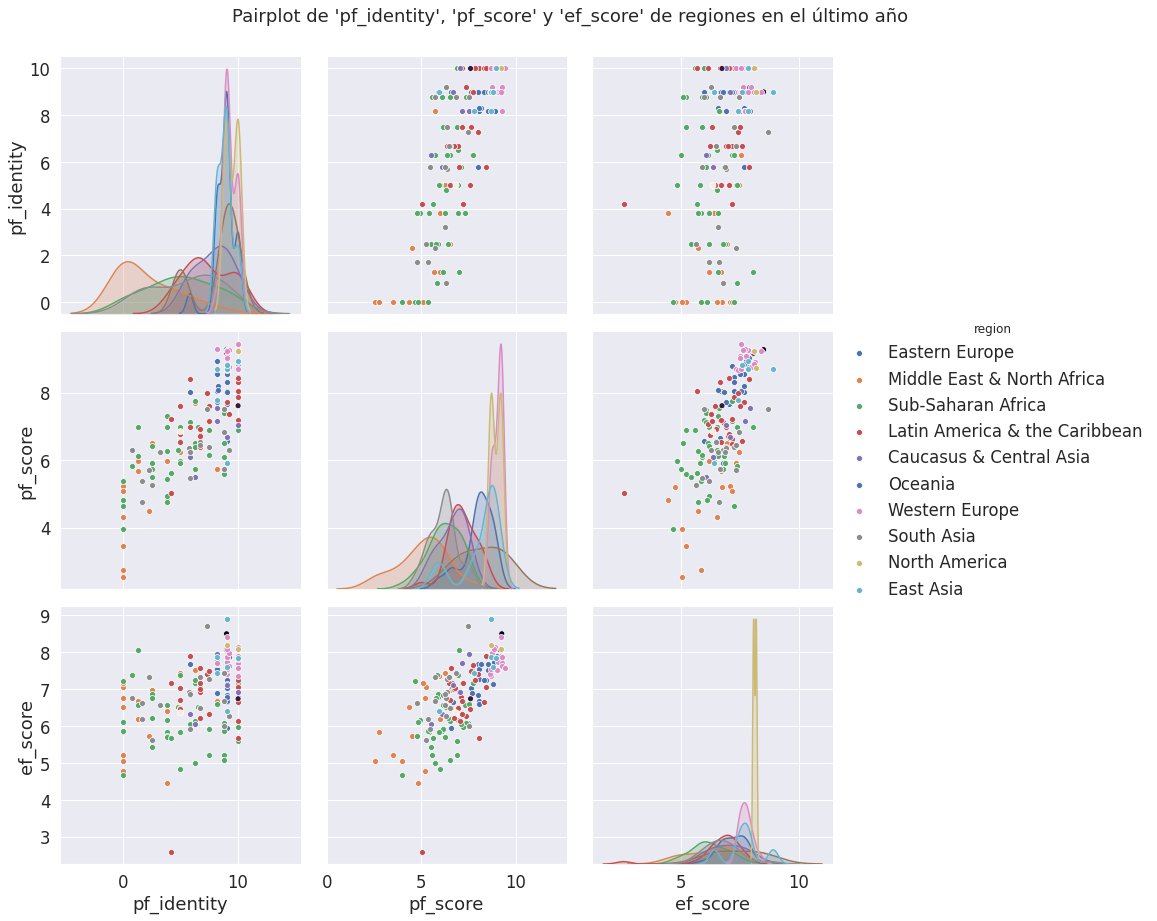

In [0]:
seaborn.pairplot(data=df_world_last_year,vars=['pf_identity','pf_score','ef_score'], hue='region', height= 4)
plt.suptitle("Pairplot de 'pf_identity', 'pf_score' y 'ef_score' de regiones en el último año", y=1.05, fontsize=18)

plt.show()

Analizando este gráfico resulta dificultoso poder responder la pregunta. Se puede ver que hay una monotonicidad con lo datos en general pero no por región.

Mediante la correlación de Kendall podemos analizar si existe una correlación entre las variables de acuerdo a las regiones. Pero para aplicar este método es necesario tener las variables rankeadas. 


Para analizar esta correlación de las variables necesitamos un nuevo dataFrame con los datos de todos lo paises del último año (2017). Para condensar los valores por región utilizamos la media y luego rankeamos por variable.

In [0]:
#obtengo los promedios de cada una de las variables de interes por región
pf_identity_mean_by_region = []
ef_score_mean_by_region = []
pf_score_mean_by_region = []
for region in regions:
    data_of_region = df_world_last_year[df_world_last_year['region'] == region]
    pf_identity_mean_by_region.append(data_of_region['pf_identity'].mean())
    ef_score_mean_by_region.append(data_of_region['ef_score'].mean())
    pf_score_mean_by_region.append(data_of_region['pf_score'].mean())

#Genero una lista rankeada
pf_identity_ranked = ss.rankdata(pf_identity_mean_by_region)
ef_score_ranked = ss.rankdata(ef_score_mean_by_region)
pf_score_ranked = ss.rankdata(pf_score_mean_by_region)

#Creo una lista con las variables

zipDatos = list(zip(regions, pf_identity_ranked, ef_score_ranked,pf_score_ranked))
#Creo una dataFrame con los nuevos valores
datos = pandas.DataFrame(zipDatos, columns=['region','pf_identity', 'ef_score','pf_score'])
datos

,region,pf_identity,ef_score,pf_score
0,Latin America & the Caribbean,3.0,2.0,4.0
1,North America,9.0,9.0,8.0
2,Sub-Saharan Africa,1.0,1.0,2.0
3,Oceania,5.0,6.0,7.0
4,Western Europe,8.0,8.0,9.0
5,Eastern Europe,6.0,5.0,5.0
6,Caucasus & Central Asia,4.0,4.0,3.0
7,South Asia,2.0,3.0,1.0
8,East Asia,7.0,7.0,6.0


Con esta nueva tabla podemos gráficar la distribución de las variables:

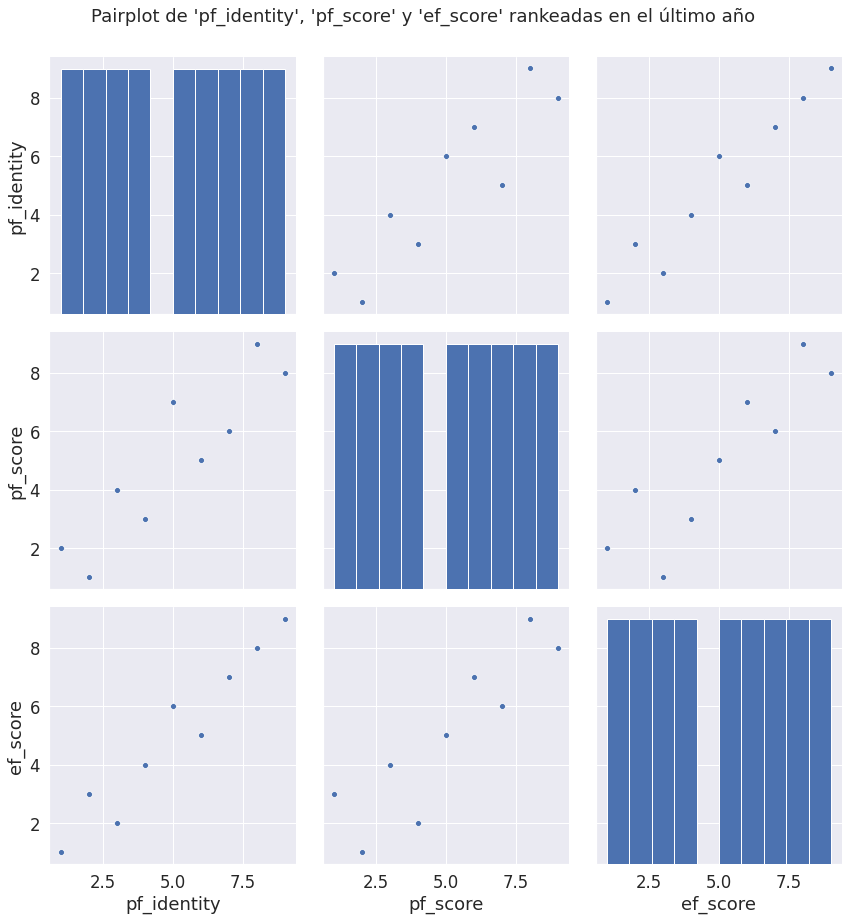

In [0]:
seaborn.pairplot(data=datos, vars=['pf_identity','pf_score','ef_score'], height=4)
plt.suptitle("Pairplot de 'pf_identity', 'pf_score' y 'ef_score' rankeadas en el último año", y=1.05, fontsize=18)

plt.show()

#### Aplicando la correlación de Kendall a los datos

Empezamos analizando "pf_identity" y "ef_score":

In [0]:
ss.kendalltau(datos['pf_identity'], datos['ef_score'])


KendalltauResult(correlation=0.8888888888888888, pvalue=0.00024250440917107584)

 Como podemos ver, existe una correlación fuerte (cerca de 0.87) entre las variables "pf_identity" y "ef_score" por región. Ademas el "pvalue" de bajo valor nos dice que podemos rechazar la $h_0$ de asociación nula entre los datos. 
 
La interpretación que se puede hacer es que las variables rankean parecido por región. Esto es: si en una región el "pf_identity" es alto, entonces tendrá un "ef_score" también alto.

De igual manera entre "pf_identity" y "pf_score":

In [0]:
ss.kendalltau(datos['pf_identity'], datos['pf_score'])

KendalltauResult(correlation=0.7222222222222222, pvalue=0.0058862433862433864)

Aquí vemos también una alta correlación entre las mismas por región.

 De igual manera entre "ef_score" y "pf_score":

In [0]:
ss.kendalltau(datos['ef_score'], datos['pf_score'])

KendalltauResult(correlation=0.7222222222222222, pvalue=0.0058862433862433864)

Vemos que también correlacionan fuerte las variables por región.